In [4]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches

import geopandas as gpd

import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import numpy as np
from shapely.geometry import Polygon, shape

import os
from itertools import compress


from dbfread import DBF

from pycirclize import Circos
from pycirclize.parser import Matrix
import pandas as pd

from functions.processing.retrieval import getSoundLocations
from functions.processing.recordings import processSingleRecording
from functions.processing.recordings import processSingleRecordingPoint
from functions.plotting.all_records import plotSingleRecording as plotSingleRecordingAll


In [2]:
points = getSoundLocations("Z:\\Audio_data\\Dawn_chorus_raw_data")

In [6]:
points, dbf_df, geo_df, filtered_dfs, grouped_dfs, weighted_frames, raster_crs = processSingleRecording(corine_dir = "F:\\Persönliches\\Git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(10))
# points, dbf_df, geo_df, filtered_dfs, grouped_dfs, weighted_frames, raster_crs = processSingleRecording(corine_dir = "C:\\Users\\mfher\\git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(72924,72925))

Loading raster.
Loaded raster successfully. 
Generated buffers.
Clipped raster to the largest buffer. 
Generating individual pixels.
Selected intersecting pixels for buffer 0.
Selected intersecting pixels for buffer 1.
Selected intersecting pixels for buffer 2.
Dropped duplicate pixels
         geometry
CODE_18          
112             6
         geometry
CODE_18          
112             6
         geometry
CODE_18          
111             2
112             8
Weighted classes:
         geometry
CODE_18          
111           2.0
112          56.0
Assigned class 112 to point 0
Generated buffers.
Clipped raster to the largest buffer. 
Generating individual pixels.
Selected intersecting pixels for buffer 0.
Selected intersecting pixels for buffer 1.
Selected intersecting pixels for buffer 2.
Dropped duplicate pixels
         geometry
CODE_18          
112             4
         geometry
CODE_18          
112             7
231             1
         geometry
CODE_18          
112      

f:\Persönliches\Git\BioOTon\functions\processing\recordings.py:168: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '112' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  points.loc[points.index==idx, 'label'] = weighted_class


In [ ]:
# points.to_parquet("points.parquet")

In [ ]:
points, dbf_df, geo_df, joined_dfs, raster_crs = processSingleRecordingPoint(corine_dir = "F:\\Persönliches\\Git\\BioOTon", recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data", x_range=np.arange(6350,6360))

In [ ]:
# points.to_parquet("points_single.parquet")

f:\Persönliches\Git\BioOTon\functions\plotting\all_records.py:48: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  val_frame.plot(ax=ax[0], legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])


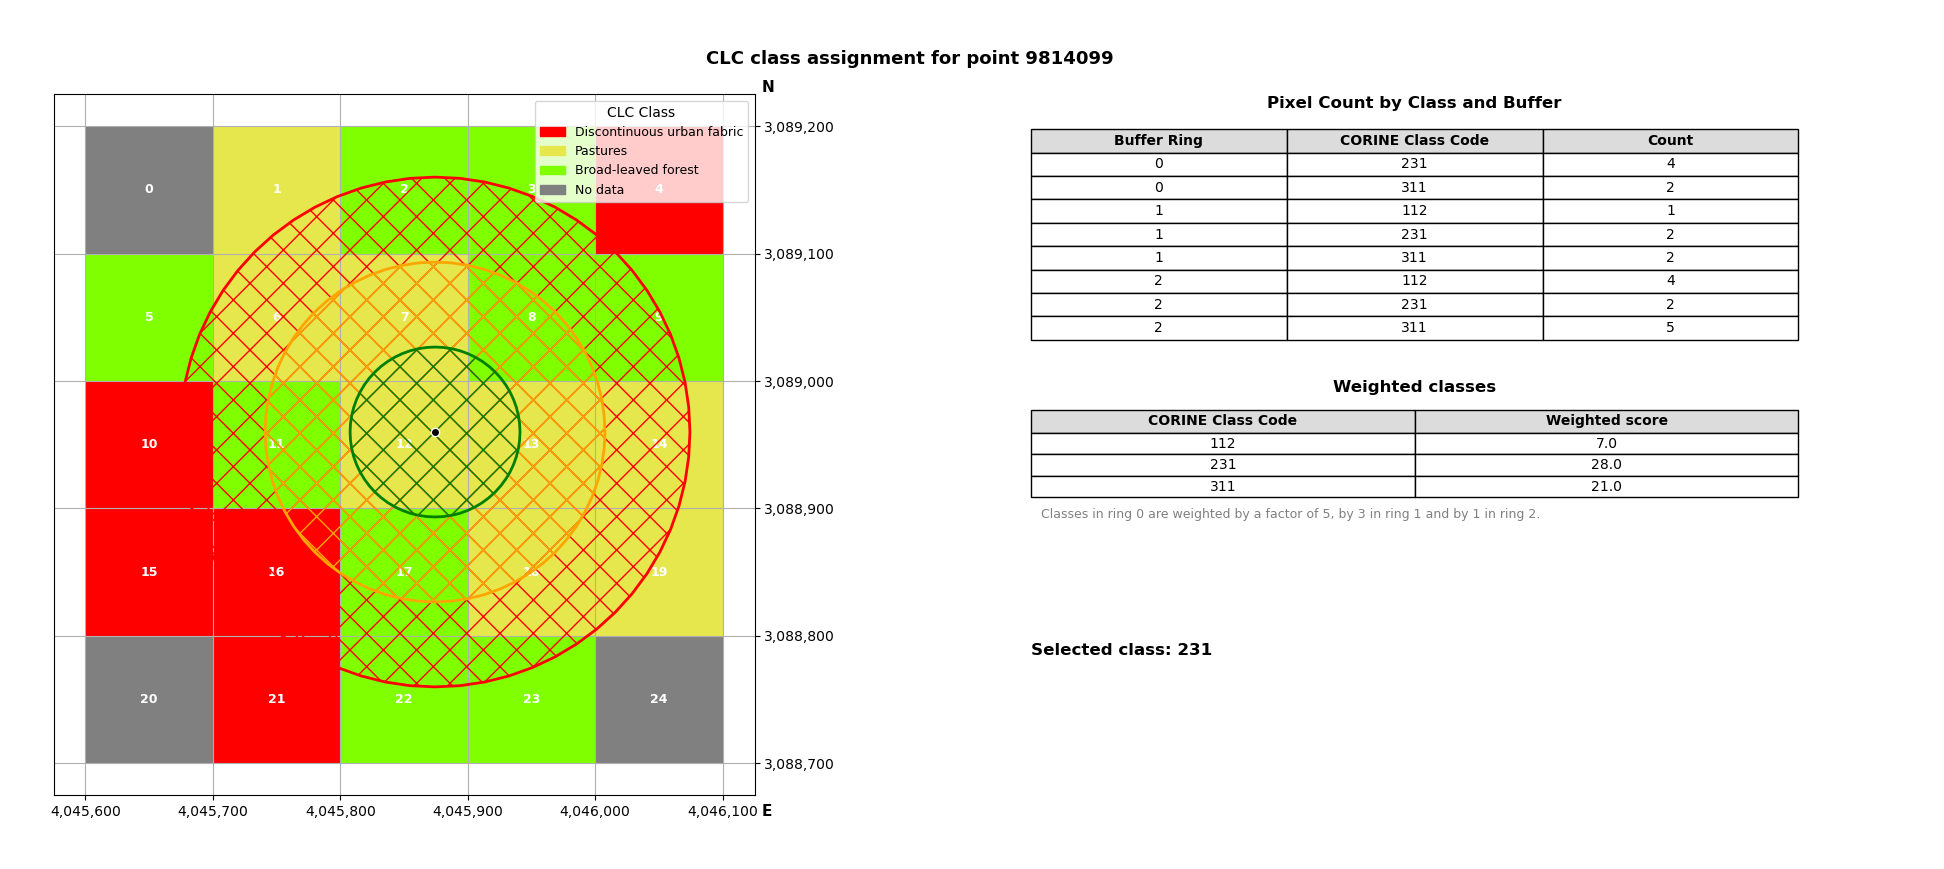

In [8]:
# Only problem with this index scheme is that the indexes are always dependent on how many points were processed previously
fig = plotSingleRecordingAll(point_idx=3, dbf_frame = dbf_df, recording_frame=points, joined_frame=filtered_dfs, environment_frame=geo_df, grouped_frames = grouped_dfs, weighted_frames = weighted_frames, raster_crs=raster_crs)

In [19]:
def plotRecord(recording_point, geodataframe, buffer_distance, raster_crs="EPSG:3035"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    geodataframe.plot(ax=ax, column="value", legend=True)

    gpd.GeoSeries(recording_point.geometry, crs=raster_crs).buffer(buffer_distance).plot(ax=ax, color='green', alpha = 0.7)
    gpd.GeoSeries(recording_point["geometry"], crs=raster_crs).plot(ax=ax, color='black', edgecolor='white')

    plt.grid()
    for idx, row in geodataframe.iterrows():
        # Get square center
        centroid_x = row.geometry.centroid.x
        centroid_y = row.geometry.centroid.y
        
        ax.annotate(
            text=str(idx),
            xy=(centroid_x, centroid_y),
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )
    return fig

In [3]:
"""
    Generates plot for given recording index.
"""
def plotOverviewSingleBuffer(point_idx, dbf_frame, recording_frame, joined_frame, environment_frame, grouped_frames, weighted_frames, raster_crs="EPSG:3035", distance=200):
    # Generate plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Set Super Title as recording number
    fig.suptitle(f"Overview of point neighbourhood for point {recording_frame.iloc[point_idx].id}", fontsize=13, fontweight='bold')


    # This value frame is needed for the CLC polygons and their legend
    # Duplicates in joined_frame have to be dropped in order to facilitate a successful merge
    unique_jdf = pd.concat(joined_frame[point_idx]).drop_duplicates(subset=['value'], keep='first').drop(columns=['geometry', 'Value'])
    val_frame = environment_frame[point_idx].merge(unique_jdf, on = "value", how="left", suffixes=('', '_r'))
    # val_frame = environment_frame.join(joined_frame, on = "value", how="left", rsuffix='_r')

    # Generate a dict using the same colors as the original CLC tiff
    color_dict = {
        code: to_hex((R, G, B)) # Matplotlib expects normalized (0.0 to 1.0) RGB first
        for code, R, G, B in zip(dbf_frame.CODE_18.values, dbf_frame.Red.values, dbf_frame.Green.values, dbf_frame.Blue.values)
    }

    # Needed to map the values to the legend descriptors
    codes = val_frame[['CODE_18', 'LABEL3']].drop_duplicates().sort_values('CODE_18')['CODE_18'].tolist()
    labels = val_frame[['CODE_18', 'LABEL3']].drop_duplicates().sort_values('CODE_18')['LABEL3'].replace(float("nan"), "No data").tolist()

    # Maps legend labels and colors
    legend_handles = [
        mpatches.Patch(
            color=color_dict.get(code, 'gray'), 
            label=label
        ) 
        for code, label in zip(codes, labels)
    ]

    # Plot all CLC classes in the area
    val_frame.plot(ax=ax, legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])

    # Generate Legend
    ax.legend(
        handles=legend_handles, 
        title="CLC Class", 
        loc='upper right', 
        frameon=True,
        fontsize=9
    )

    # Plot annotations, mainly index to the CLC classes
    for idx, row in val_frame.iterrows():
        # Get square center
        centroid_x = row.geometry.centroid.x
        centroid_y = row.geometry.centroid.y
        ax.annotate(
            text=f"{str(idx)}",
            # Comment out below unless you want to do a sanity check
            #text=f"{str(idx)} (c: {(row.CODE_18)})",
            xy=(centroid_x, centroid_y),
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )


    # Disable scientific format and format ticks so that they use , to separate steps of 1000
    ax.ticklabel_format(style='plain', useOffset=False, axis='both')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    formatter = ticker.StrMethodFormatter('{x:,.0f}')

    # Apply formatting
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    # Add y axis label
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()


    # Add y axis label
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    x_pos = xmax + (xmax - xmin) * 0.01
    y_pos = ymax + (ymax - ymin) * 0.02

    ax.text(
        x_pos, 
        y_pos,
        "N",
        ha='left',
        va='top',
        fontsize=11,
        fontweight='bold',
        clip_on=False
    )

    # Add x axis label
    y_pos = ymin - (ymax - ymin) * 0.0125

    ax.text(
        x_pos, 
        y_pos,
        "E",
        ha='left',
        va='top',
        fontsize=11,
        fontweight='bold',
        clip_on=False
    )


    # Generate buffer colors
    colors = ["red", "orange", "green"]

    # Plot buffer
    gpd.GeoSeries(recording_point.geometry, crs=raster_crs).buffer(buffer_distance).plot(
            ax=ax, 
            facecolor='none',
            hatch='X', 
            edgecolor='black', 
            alpha=1.0,
            linewidth=2,
            zorder=5
        )

    # Plot the recording point
    ax.scatter(recording_frame.iloc[point_idx].geometry.x, recording_frame.iloc[point_idx].geometry.y,  color='black', edgecolor='white', zorder=10)

    # Generate a grid at every 100m
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.grid()

    plt.tight_layout()

    return fig

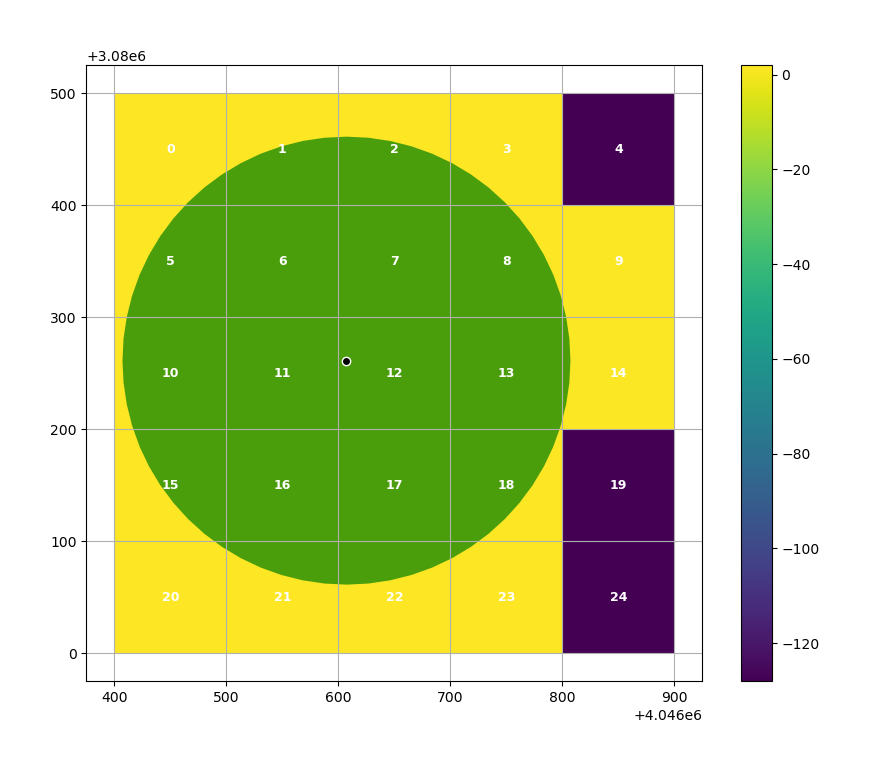

In [20]:
fig = plotRecord(points.iloc[0], geo_df[0], 200)

In [ ]:
def plotRecordMultiBuffer(geodataframe, buffers):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    geodataframe.plot(ax=ax, column="CODE_18", legend=True)

    colors = ["red", "orange", "green"]
    for idx, x in enumerate(list(reversed(buffers))):
        x.plot(ax=ax, facecolor=None, hatch='XX', edgecolor=colors[idx], alpha=0.7)
    gpd.GeoSeries(sound_point["geometry"], crs="EPSG:3035").plot(ax=ax, color='black', edgecolor='white')
    plt.grid()
    for idx, row in geodataframe.iterrows():
        # Get square center
        centroid_x = row.geometry.centroid.x
        centroid_y = row.geometry.centroid.y
        
        ax.annotate(
            text=str(idx),
            xy=(centroid_x, centroid_y),
            ha='center',
            va='center',
            fontsize=9,
            color='white',
            fontweight='bold'
        )
    return fig

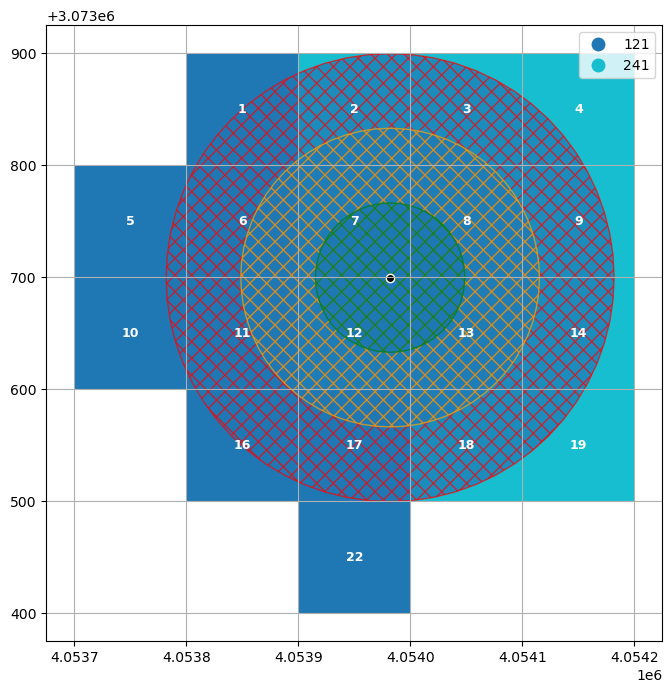

In [239]:
fig = plotRecordMultiBuffer(jdf, buffers)

In [6]:
pframe = pd.read_parquet("points.parquet")

In [7]:
pframe["geometry"] = gpd.GeoSeries.from_wkb(pframe.geometry).buffer(200, cap_style='square')

In [8]:
pframe[pframe.label==-128]

,id,geometry,label
72924,16169196,"POLYGON ((4046770.021 3127677.694, 4046770.021...",-128


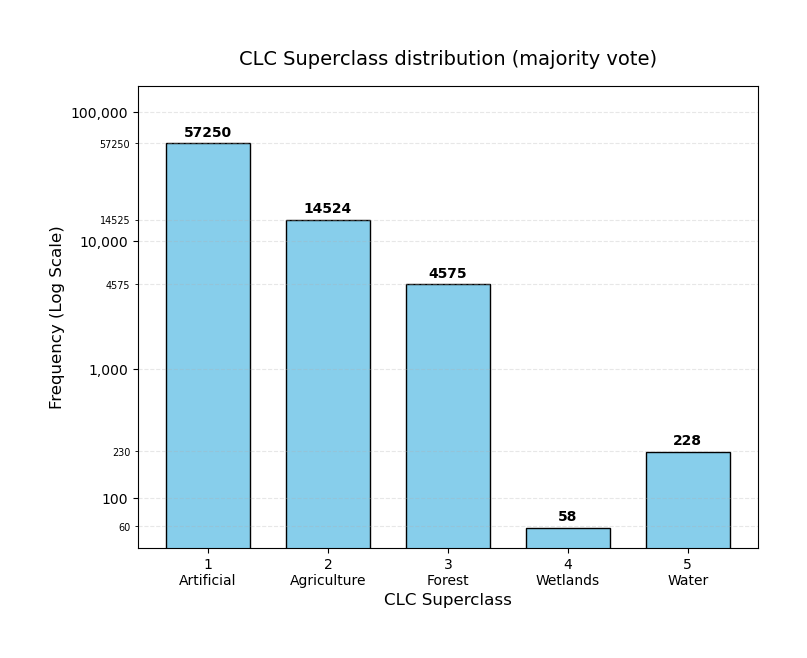

In [75]:
counts = pframe.loc[pframe.label > 0, "label"].astype(str).str[0].astype(int).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(counts.index, counts.values, color='skyblue', edgecolor='black', log=True, width=0.7)

bar_heights = [int(5*round(rect.get_height()/5)) for rect in bars]

ax.set_yticks(bar_heights, minor=True)

ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
formatter = ticker.StrMethodFormatter('{x:,.0f}')

ax.tick_params(axis='y', which='minor', labelsize=7)

ax.bar_label(bars, padding=3, fontsize=10, fontweight='bold')
ax.set_title("CLC Superclass distribution (majority vote)", fontsize=14, pad=15)
ax.set_xlabel("CLC Superclass", fontsize=12)
ax.set_ylabel("Frequency (Log Scale)", fontsize=12)
ax.set_xticks(range(1, 6))
ax.set_xticklabels(["1\nArtificial", "2\nAgriculture", "3\nForest", "4\nWetlands", "5\nWater"])

ax.set_ylim(top=ax.get_ylim()[1] * 2) 

plt.grid(axis='y', which='both', linestyle='--', alpha=0.3)
plt.show()

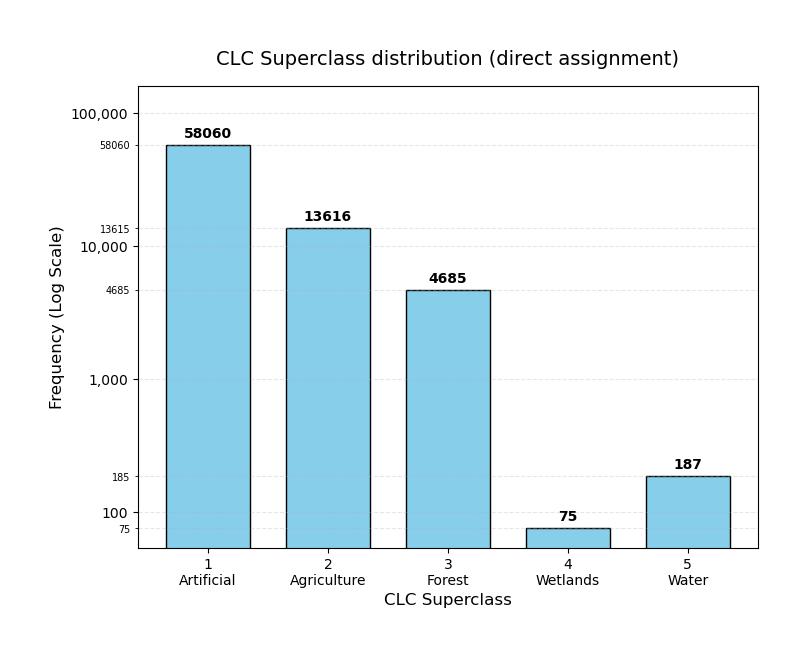

In [74]:
counts = pframe_single.loc[pd.to_numeric(pframe_single.label) > 0, "label"].astype(str).str[0].astype(int).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(counts.index, counts.values, color='skyblue', edgecolor='black', log=True, width=0.7)

bar_heights = [int(5*round(rect.get_height()/5)) for rect in bars]

ax.set_yticks(bar_heights, minor=True)

ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
formatter = ticker.StrMethodFormatter('{x:,.0f}')

ax.tick_params(axis='y', which='minor', labelsize=7)

ax.bar_label(bars, padding=3, fontsize=10, fontweight='bold')
ax.set_title("CLC Superclass distribution (direct assignment)", fontsize=14, pad=15)
ax.set_xlabel("CLC Superclass", fontsize=12)
ax.set_ylabel("Frequency (Log Scale)", fontsize=12)
ax.set_xticks(range(1, 6))
ax.set_xticklabels(["1\nArtificial", "2\nAgriculture", "3\nForest", "4\nWetlands", "5\nWater"])

ax.set_ylim(top=ax.get_ylim()[1] * 2) 

plt.grid(axis='y', which='both', linestyle='--', alpha=0.3)
plt.show()

C:\Users\mfher\AppData\Local\Temp\ipykernel_3424\3881549399.py:69: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[1].set_ylim(top=ax[1].get_ylim()[1] * 5)


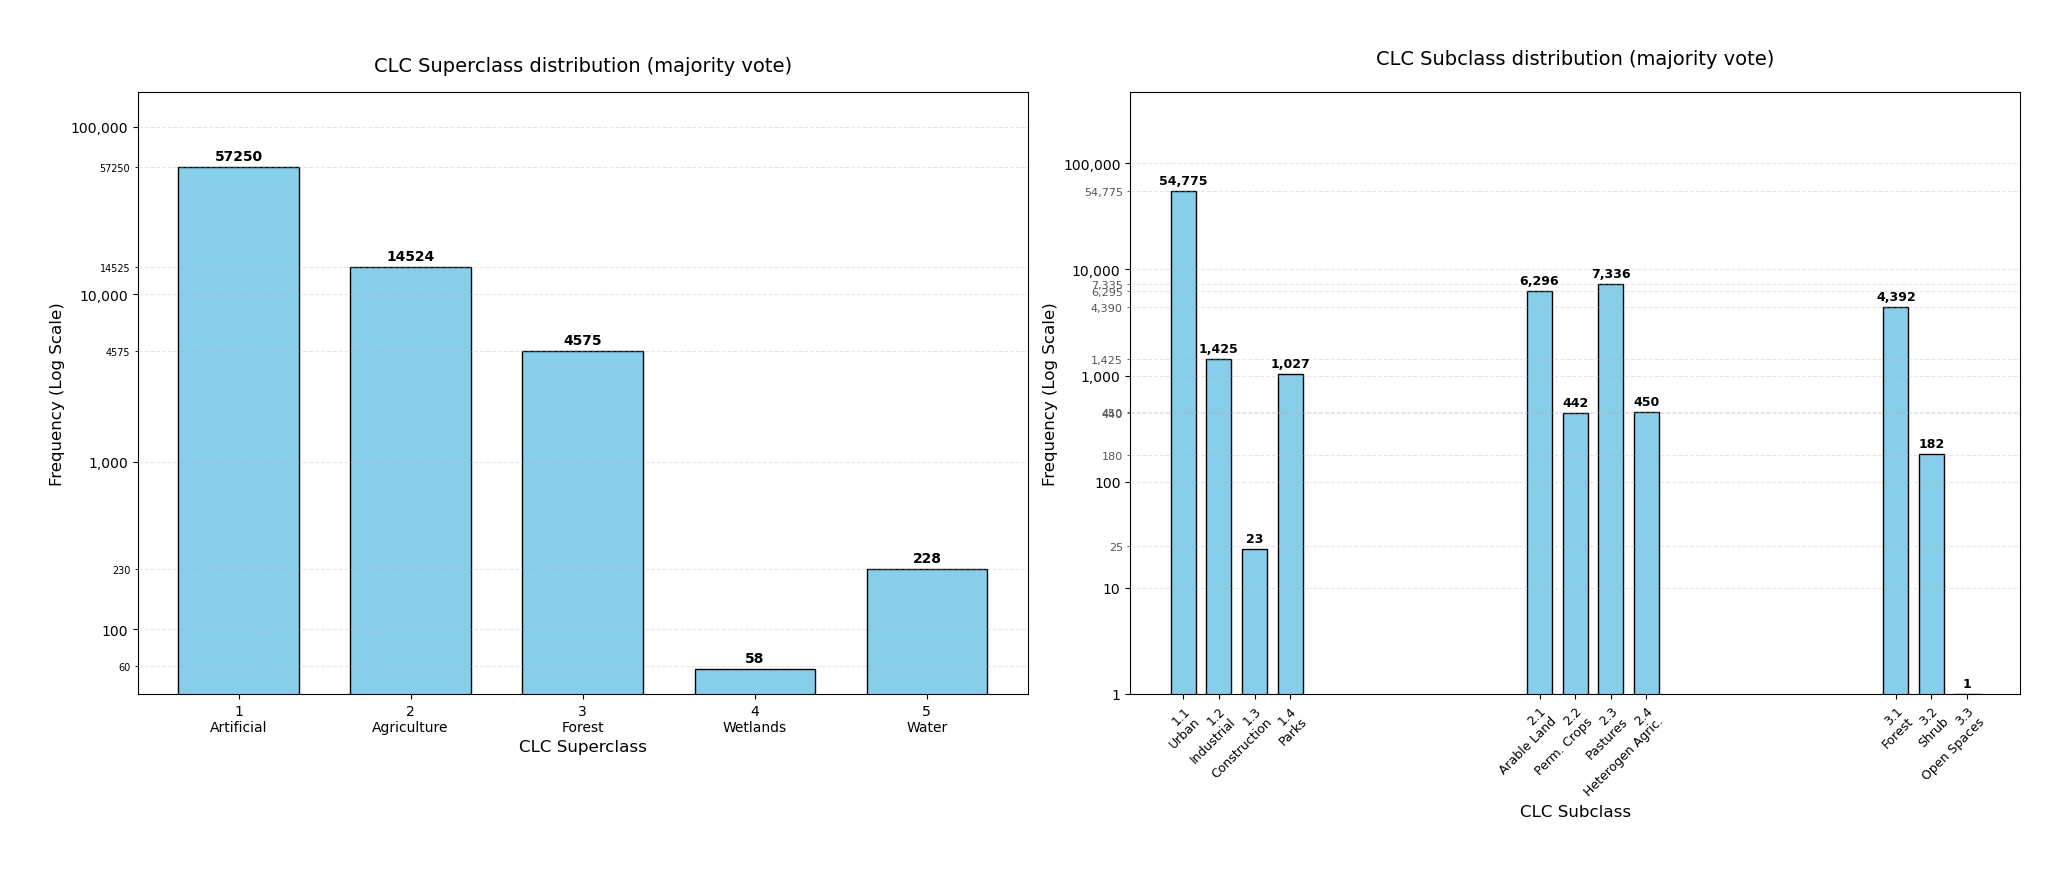

In [80]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# --- Data Preparation ---
# Superclass data
counts_super = pframe.loc[pframe.label > 0, "label"].astype(str).str[0].astype(int).value_counts().sort_index()

# Subclass data
counts_sub = pframe.loc[pframe.label > 0, "label"].astype(str).str[:2].astype(int).value_counts().sort_index()
counts_sub = counts_sub[counts_sub.index < 40]

# --- Create Figure with 2 Subplots ---
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ==========================================
# LEFT PLOT: CLC Superclass
# ==========================================
bars1 = ax[0].bar(counts_super.index, counts_super.values, color='skyblue', edgecolor='black', log=True, width=0.7)

# Minor tick logic
bar_heights1 = [int(5*round(rect.get_height()/5)) for rect in bars1]
ax[0].set_yticks(bar_heights1, minor=True)
ax[0].yaxis.set_minor_formatter(ticker.ScalarFormatter())
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].tick_params(axis='y', which='minor', labelsize=7)

ax[0].bar_label(bars1, padding=3, fontsize=10, fontweight='bold')
ax[0].set_title("CLC Superclass distribution (majority vote)", fontsize=14, pad=15)
ax[0].set_xlabel("CLC Superclass", fontsize=12)
ax[0].set_ylabel("Frequency (Log Scale)", fontsize=12)
ax[0].set_xticks(range(1, 6))
ax[0].set_xticklabels(["1\nArtificial", "2\nAgriculture", "3\nForest", "4\nWetlands", "5\nWater"])
ax[0].set_ylim(top=ax[0].get_ylim()[1] * 2) 
ax[0].grid(axis='y', which='both', linestyle='--', alpha=0.3)

# ==========================================
# RIGHT PLOT: CLC Subclass
# ==========================================
bars2 = ax[1].bar(counts_sub.index, counts_sub.values, color='skyblue', edgecolor='black', log=True, width=0.7)

# Minor tick logic with major overlap prevention
bar_heights2 = [int(5*round(rect.get_height()/5)) for rect in bars2]
majors = 10 ** np.arange(8)
for b in list(bar_heights2): # Iterate over a copy to allow removal
    for i in majors:
        if (b/i > 0.9) & (b/i < 1.1): # Simplified overlap check
            if b in bar_heights2: bar_heights2.remove(b)

ax[1].set_yticks(bar_heights2, minor=True)
fmt = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax[1].yaxis.set_minor_formatter(fmt)
ax[1].yaxis.set_major_formatter(fmt)
ax[1].tick_params(axis='y', which='minor', labelsize=8, colors='#555555')

ax[1].set_xticks(counts_sub.index.values)
ax[1].set_xticklabels(
    ["1.1\nUrban", "1.2\nIndustrial", "1.3\nConstruction", "1.4\nParks", 
     "2.1\nArable Land", "2.2\nPerm. Crops", "2.3\nPastures", "2.4\nHeterogen Agric.",
     "3.1\nForest", "3.2\nShrub", "3.3\nOpen Spaces"],
    rotation=45, ha='right', fontsize=9, rotation_mode="anchor"
)

ax[1].bar_label(bars2, padding=3, fontsize=9, fontweight='bold', 
                labels=[f'{int(x):,}' for x in counts_sub.values])
ax[1].set_title("CLC Subclass distribution (majority vote)", fontsize=14, pad=20)
ax[1].set_xlabel("CLC Subclass", fontsize=12)
ax[1].set_ylabel("Frequency (Log Scale)", fontsize=12)
ax[1].set_ylim(top=ax[1].get_ylim()[1] * 5)
ax[1].grid(axis='y', which='both', linestyle='--', alpha=0.3)

# --- Final Adjustments ---
plt.tight_layout()
plt.show()

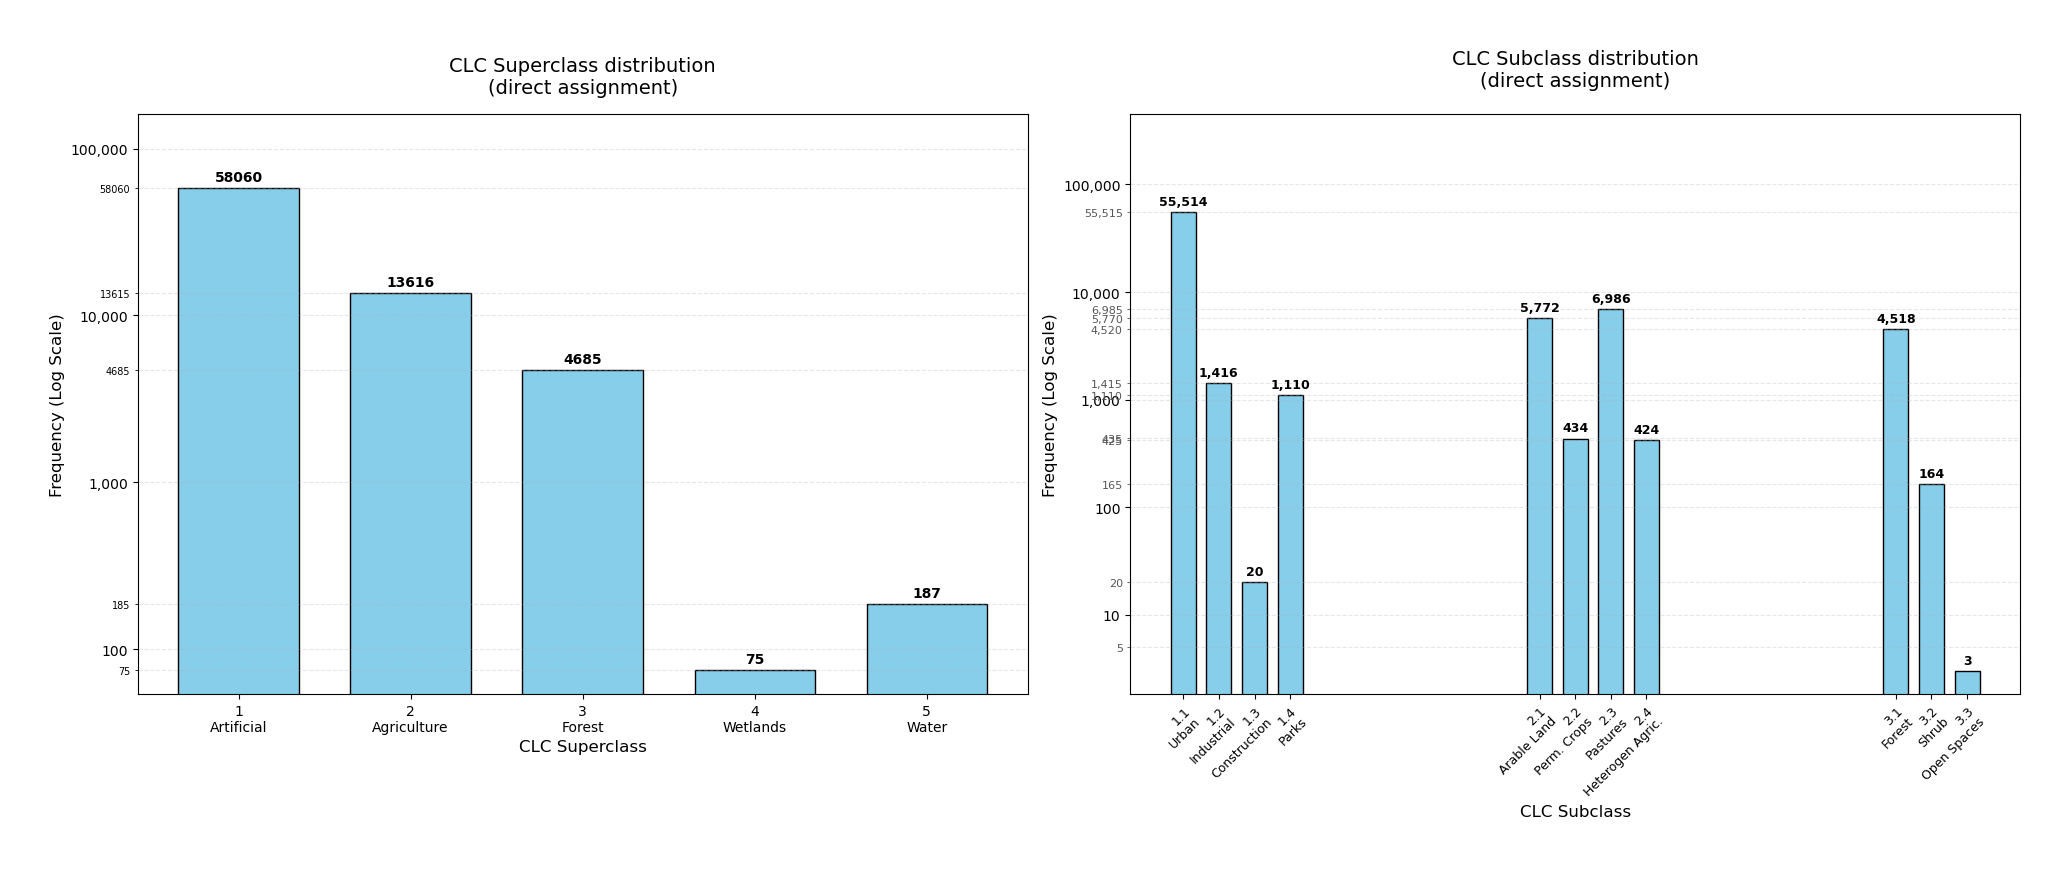

In [82]:
# --- Data Preparation ---
# Superclass data (Direct Assignment)
counts_super = pframe_single.loc[pd.to_numeric(pframe_single.label) > 0, "label"].astype(str).str[0].astype(int).value_counts().sort_index()

# Subclass data (Direct Assignment)
counts_sub = pframe_single.loc[pd.to_numeric(pframe_single.label) > 0, "label"].astype(str).str[:2].astype(int).value_counts().sort_index()
counts_sub = counts_sub[counts_sub.index < 40]

# --- Create Figure with 2 Subplots ---
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# ==========================================
# LEFT PLOT: CLC Superclass (Direct)
# ==========================================
bars1 = ax[0].bar(counts_super.index, counts_super.values, color='skyblue', edgecolor='black', log=True, width=0.7)

# Minor tick logic
bar_heights1 = [int(5*round(rect.get_height()/5)) for rect in bars1]
ax[0].set_yticks(bar_heights1, minor=True)
ax[0].yaxis.set_minor_formatter(ticker.ScalarFormatter())
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax[0].tick_params(axis='y', which='minor', labelsize=7)

ax[0].bar_label(bars1, padding=3, fontsize=10, fontweight='bold')
ax[0].set_title("CLC Superclass distribution\n(direct assignment)", fontsize=14, pad=15)
ax[0].set_xlabel("CLC Superclass", fontsize=12)
ax[0].set_ylabel("Frequency (Log Scale)", fontsize=12)
ax[0].set_xticks(range(1, 6))
ax[0].set_xticklabels(["1\nArtificial", "2\nAgriculture", "3\nForest", "4\nWetlands", "5\nWater"])
ax[0].set_ylim(top=ax[0].get_ylim()[1] * 2) 
ax[0].grid(axis='y', which='both', linestyle='--', alpha=0.3)

# ==========================================
# RIGHT PLOT: CLC Subclass (Direct)
# ==========================================
bars2 = ax[1].bar(counts_sub.index, counts_sub.values, color='skyblue', edgecolor='black', log=True, width=0.7)

# Minor tick logic with major overlap prevention
bar_heights2 = [int(5*round(rect.get_height()/5)) for rect in bars2]
for b in list(bar_heights2):
    majors = 10 ** np.arange(8)
    for i in majors:
        if (b/i > 1) & (b/i < 1.1):
            if b in bar_heights2: bar_heights2.remove(b)

ax[1].set_yticks(bar_heights2, minor=True)
fmt = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax[1].yaxis.set_minor_formatter(fmt)
ax[1].yaxis.set_major_formatter(fmt)
ax[1].tick_params(axis='y', which='minor', labelsize=8, colors='#555555')

ax[1].set_xticks(counts_sub.index.values)
ax[1].set_xticklabels(
    ["1.1\nUrban", "1.2\nIndustrial", "1.3\nConstruction", "1.4\nParks", 
     "2.1\nArable Land", "2.2\nPerm. Crops", "2.3\nPastures", "2.4\nHeterogen Agric.",
     "3.1\nForest", "3.2\nShrub", "3.3\nOpen Spaces"],
    rotation=45, ha='right', fontsize=9, rotation_mode="anchor"
)

ax[1].bar_label(bars2, padding=3, fontsize=9, fontweight='bold', 
                labels=[f'{int(x):,}' for x in counts_sub.values])
ax[1].set_title("CLC Subclass distribution\n(direct assignment)", fontsize=14, pad=20)
ax[1].set_xlabel("CLC Subclass", fontsize=12)
ax[1].set_ylabel("Frequency (Log Scale)", fontsize=12)
ax[1].set_ylim(top=ax[1].get_ylim()[1] * 5)
ax[1].grid(axis='y', which='both', linestyle='--', alpha=0.3)

# --- Final Adjustments ---
plt.tight_layout()
plt.show()

C:\Users\mfher\AppData\Local\Temp\ipykernel_3424\1783528134.py:47: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(top=ax.get_ylim()[1] * 5)


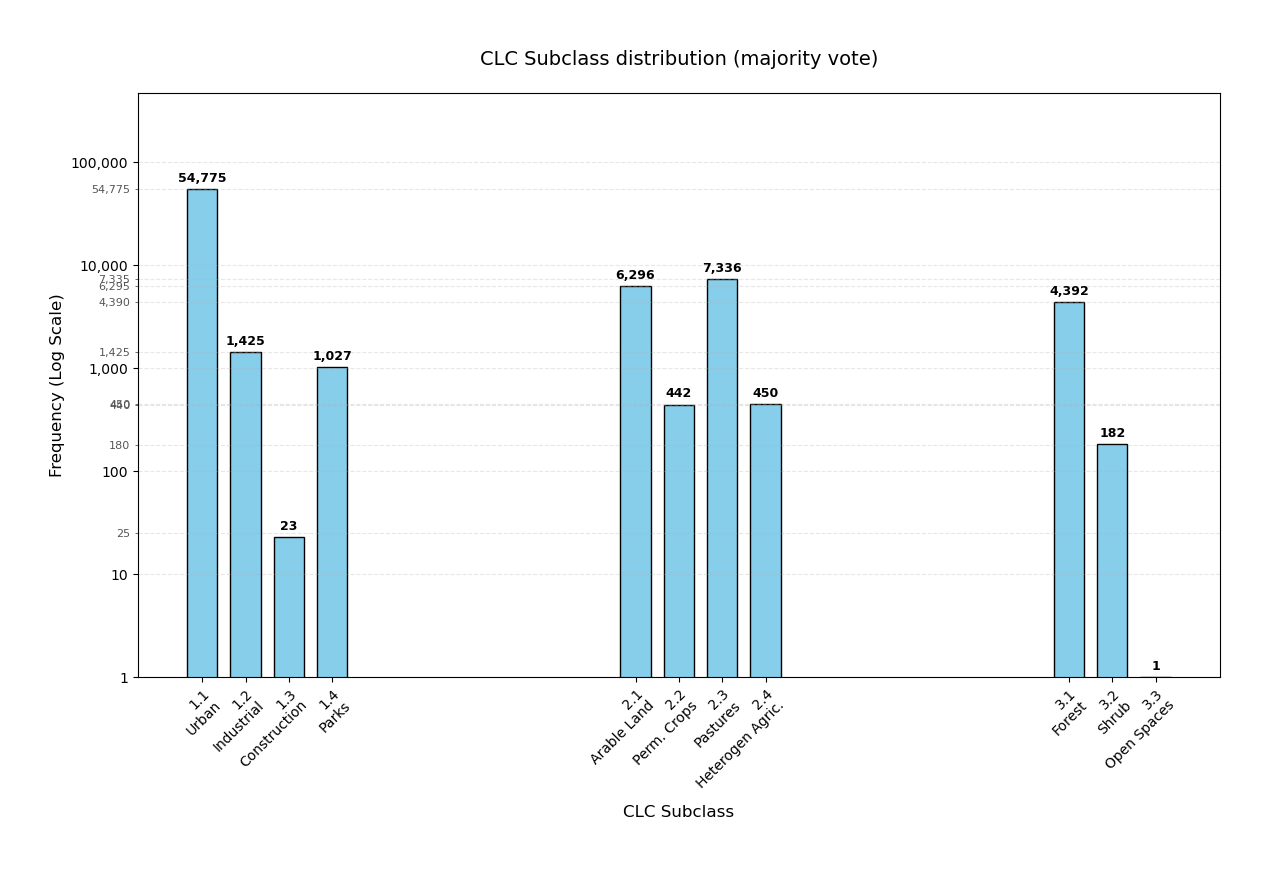

In [76]:
count = pframe.loc[pframe.label > 0, "label"].astype(str).str[:2].astype(int).value_counts().sort_index()
count = count[count.index < 40]

dbf_df["CODE2"] = dbf_df.loc[dbf_df["CODE_18"].astype(int) > 0, "CODE_18"].astype(str).str[:2].astype(int)

labels = dbf_df[(dbf_df["CODE_18"].astype(int) > 0) & (dbf_df["CODE_18"].astype(int) < 400)].drop_duplicates("CODE2").CODE2

fig, ax = plt.subplots(figsize=(12, 8)) # Adjusted figsize for a single plot
bars = ax.bar(count.index, count.values, color='skyblue', edgecolor='black', log=True, width=0.7)

bar_heights = [int(5*round(rect.get_height()/5)) for rect in bars]

for b in bar_heights:
    majors= 10 ** np.arange(6)
    for i in majors:
        if (b/i > 1) & (b/i < 1.1):
            bar_heights.remove(b)

ax.set_yticks(bar_heights, minor=True)

fmt = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.yaxis.set_minor_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.tick_params(axis='y', which='minor', labelsize=8, colors='#555555')

ax.set_xticks(count.index.values)

ax.set_xticklabels(
    ["1.1\nUrban", "1.2\nIndustrial", "1.3\nConstruction", "1.4\nParks", 
     "2.1\nArable Land", "2.2\nPerm. Crops", "2.3\nPastures", "2.4\nHeterogen Agric.",
     "3.1\nForest", "3.2\nShrub", "3.3\nOpen Spaces"],
    rotation=45, 
    ha='right',
    fontsize=10,
    rotation_mode="anchor"
)

# Adding bar labels
ax.bar_label(bars, padding=3, fontsize=9, fontweight='bold', 
             labels=[f'{int(x):,}' for x in count.values])

ax.set_title("CLC Subclass distribution (majority vote)", fontsize=14, pad=20)
ax.set_xlabel("CLC Subclass", fontsize=12, labelpad=10)
ax.set_ylabel("Frequency (Log Scale)", fontsize=12)

# Increase top margin to prevent bar labels from cutting off
ax.set_ylim(top=ax.get_ylim()[1] * 5)

plt.grid(axis='y', which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

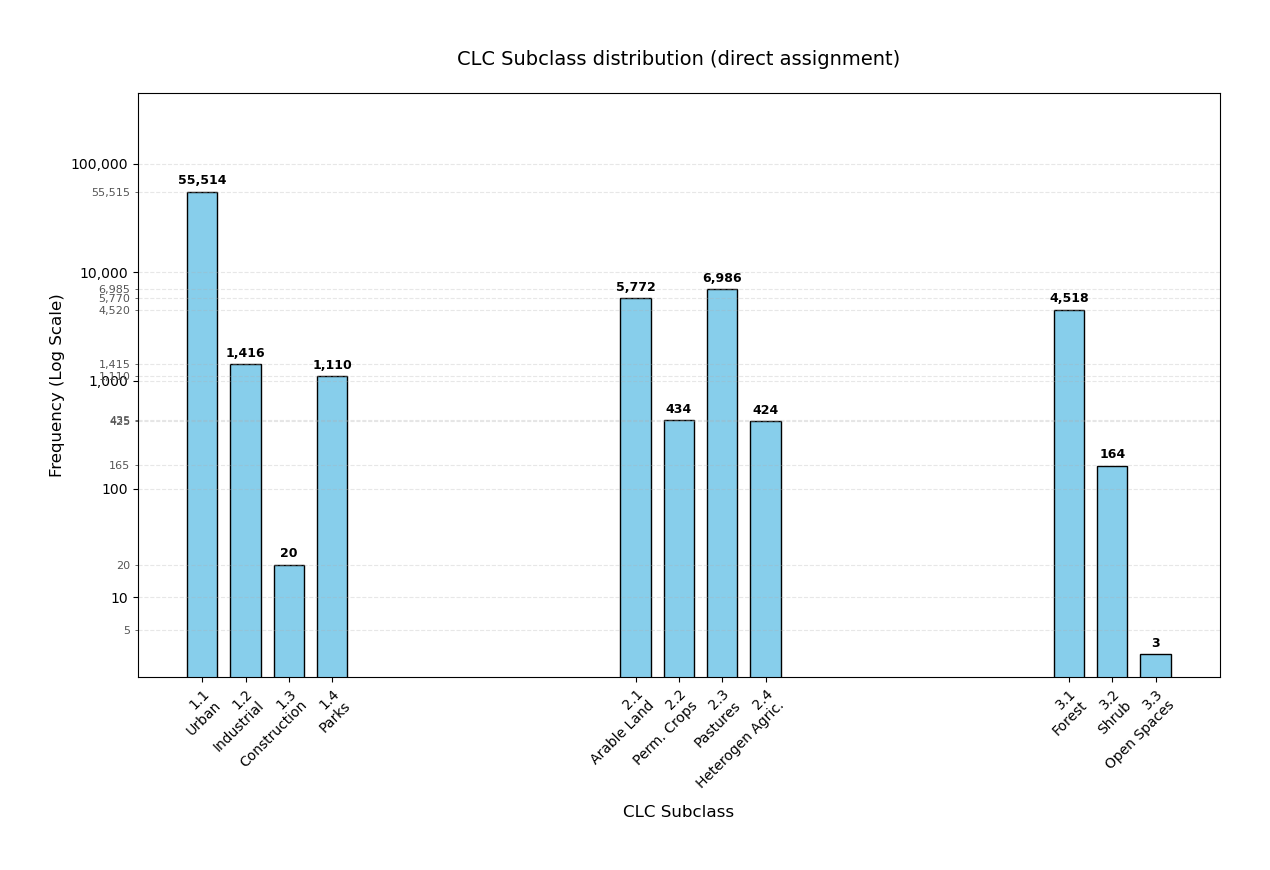

In [78]:
count = pframe_single.loc[pd.to_numeric(pframe_single.label) > 0, "label"].astype(str).str[:2].astype(int).value_counts().sort_index()
count = count[count.index < 40]

dbf_df["CODE2"] = dbf_df.loc[dbf_df["CODE_18"].astype(int) > 0, "CODE_18"].astype(str).str[:2].astype(int)

labels = dbf_df[(dbf_df["CODE_18"].astype(int) > 0) & (dbf_df["CODE_18"].astype(int) < 400)].drop_duplicates("CODE2").CODE2

fig, ax = plt.subplots(figsize=(12, 8)) # Adjusted figsize for a single plot
bars = ax.bar(count.index, count.values, color='skyblue', edgecolor='black', log=True, width=0.7)

bar_heights = [int(5*round(rect.get_height()/5)) for rect in bars]

for b in bar_heights:
    majors= 10 ** np.arange(6)
    for i in majors:
        if (b/i > 1) & (b/i < 1.1):
            bar_heights.remove(b)

ax.set_yticks(bar_heights, minor=True)

fmt = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.yaxis.set_minor_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.tick_params(axis='y', which='minor', labelsize=8, colors='#555555')

ax.set_xticks(count.index.values)

ax.set_xticklabels(
    ["1.1\nUrban", "1.2\nIndustrial", "1.3\nConstruction", "1.4\nParks", 
     "2.1\nArable Land", "2.2\nPerm. Crops", "2.3\nPastures", "2.4\nHeterogen Agric.",
     "3.1\nForest", "3.2\nShrub", "3.3\nOpen Spaces"],
    rotation=45, 
    ha='right',
    fontsize=10,
    rotation_mode="anchor"
)

# Adding bar labels
ax.bar_label(bars, padding=3, fontsize=9, fontweight='bold', 
             labels=[f'{int(x):,}' for x in count.values])

ax.set_title("CLC Subclass distribution (direct assignment)", fontsize=14, pad=20)
ax.set_xlabel("CLC Subclass", fontsize=12, labelpad=10)
ax.set_ylabel("Frequency (Log Scale)", fontsize=12)

# Increase top margin to prevent bar labels from cutting off
ax.set_ylim(top=ax.get_ylim()[1] * 5)

plt.grid(axis='y', which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
pframe_single = pd.read_parquet("points_single.parquet")
pframe_single["geometry"] = gpd.GeoSeries.from_wkb(pframe_single.geometry).buffer(200, cap_style='square')

In [13]:
pframe = pd.read_parquet("points.parquet")
pframe["geometry"] = gpd.GeoSeries.from_wkb(pframe.geometry).buffer(200, cap_style='square')

In [15]:
change_frame = pframe_single.join(pframe, rsuffix="_drop")
change_frame.drop(columns=["id_drop", "geometry_drop"], inplace=True)
change_frame["change"] = change_frame["label"].astype(str) != change_frame["label_drop"].astype(str)
change_frame["change_classes"] = change_frame["label"].astype(str) + "-" +change_frame["label_drop"].astype(str)
change_frame["interclass_change"] = list(map(lambda x: x[0]!=x[4], change_frame["change_classes"]))
change_gframe = gpd.GeoDataFrame(change_frame, geometry="geometry", crs=raster_crs)

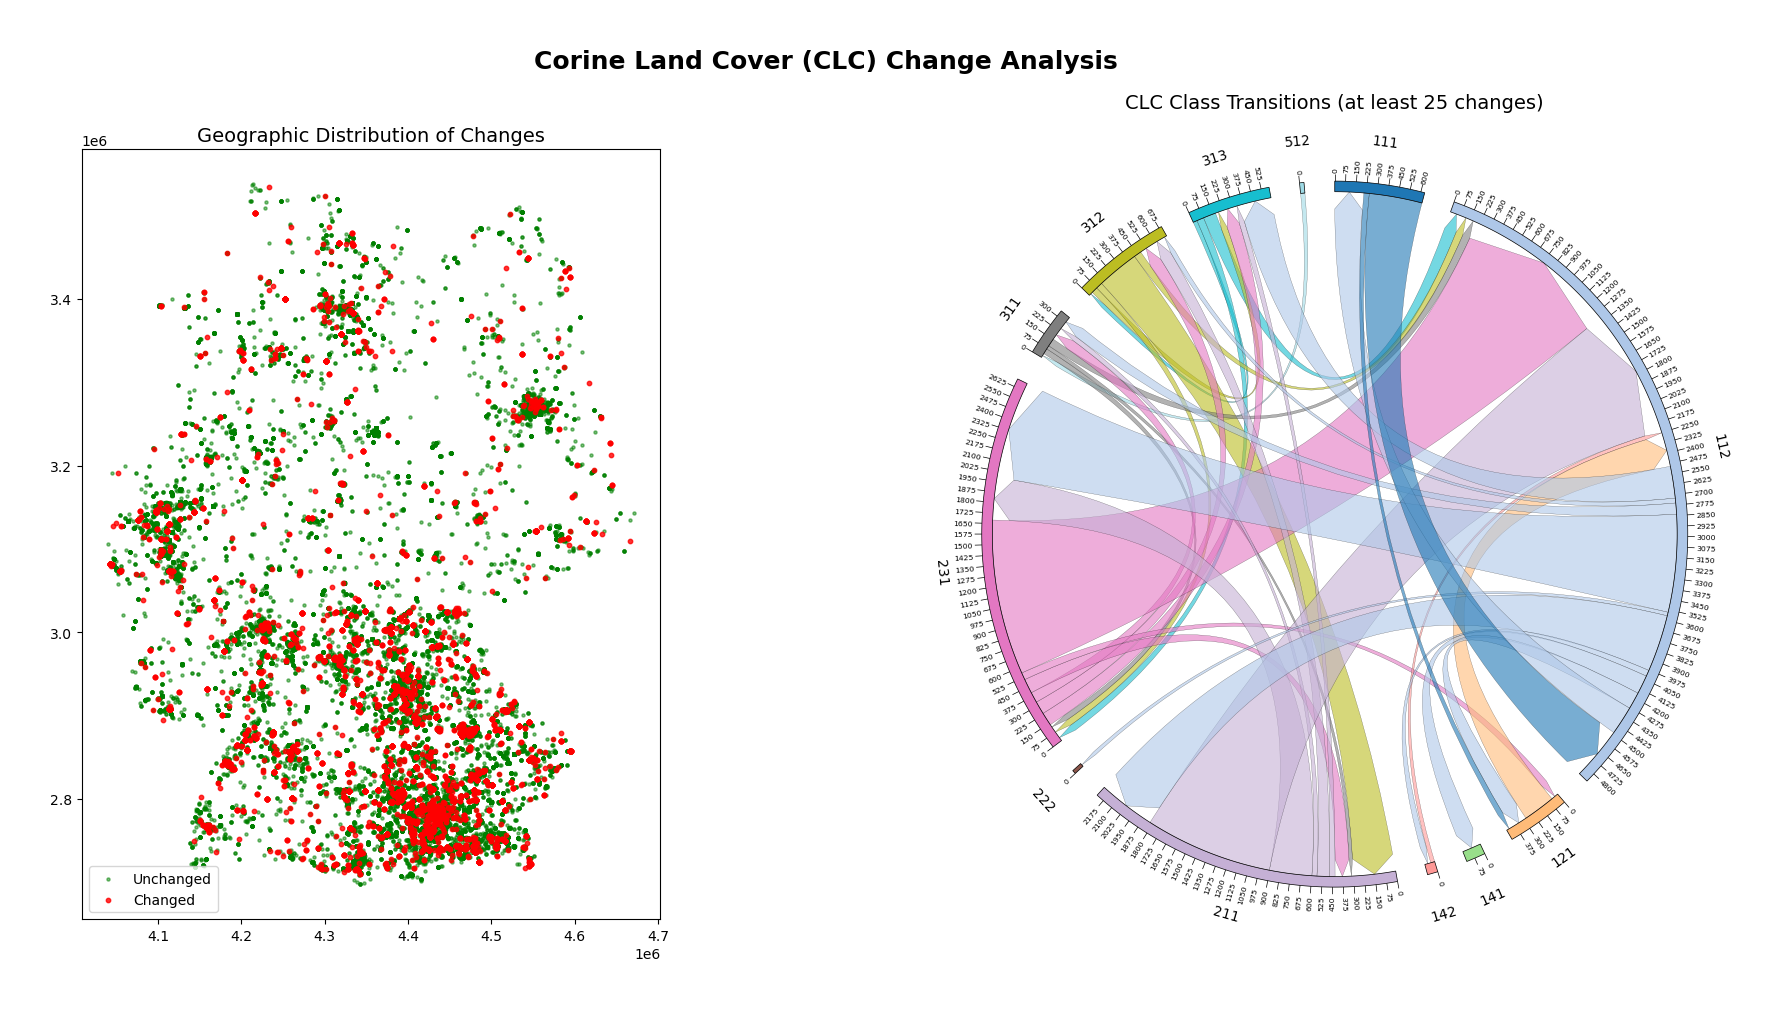

In [48]:
# Prepare Chord Data
changes_only = change_gframe[change_gframe["change"] == True].copy()
fromto_df = (
    changes_only.groupby(["label_drop", "label"])
    .size()
    .reset_index(name="value")
)
fromto_df.columns = ["from", "to", "value"]

# Filter for significance and remove self-transitions (where label didn't actually change)
fromto_df = fromto_df[(fromto_df["value"] > 25) & (fromto_df["from"] != fromto_df["to"])]

# Initialize Chord Diagram
matrix = Matrix.parse_fromto_table(fromto_df)
circos = Circos.initialize_from_matrix(
    matrix,
    space=5,
    cmap="tab20",
    ticks_interval=75,
    ticks_kws=dict(label_orientation="vertical", label_size=5.5),
    label_kws=dict(size=10, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.2, alpha=0.6),
)

# Create the Figure and Subplots
fig = plt.figure(figsize=(22, 10))

# Standard subplot for the Map
ax_map = fig.add_subplot(121) 

# POLAR subplot for the Chord Diagram
ax_chord = fig.add_subplot(122, projection="polar") 


change_gframe.plot(ax=ax_map, color='lightgrey', edgecolor='none', alpha=0.3)

# Unchanged centroids
no_changes = change_gframe[change_gframe["change"] == False].copy()
if not no_changes.empty:
    no_changes['geometry'] = no_changes.geometry.centroid
    no_changes.plot(ax=ax_map, color='green', markersize=5, alpha=0.5, label='Unchanged')

# Changed centroids
changes = change_gframe[change_gframe["change"] == True].copy()
if not changes.empty:
    changes['geometry'] = changes.geometry.centroid
    changes.plot(ax=ax_map, color='red', markersize=10, alpha=0.8, label='Changed')

ax_map.set_title("Geographic Distribution of Changes", fontsize=14)
ax_map.legend(loc='lower left')

circos.plotfig(ax=ax_chord)
ax_chord.set_title("CLC Class Transitions (at least 25 changes)", fontsize=14, pad=40)

# Final Layout Adjustments
fig.suptitle("Corine Land Cover (CLC) Change Analysis", fontsize=18, fontweight="bold", y=0.98)
plt.subplots_adjust(wspace=0.3) # Add space between the two plots
plt.show()

In [71]:
change_gframe[(pd.to_numeric(change_frame.label) < 400) & (change_frame.change==True)]

,id,geometry,label,label_drop,change,change_classes,interclass_change
10,9812980,"POLYGON ((4054102.011 3073884.169, 4054102.011...",231,112,True,231-112,True
11,9813001,"POLYGON ((4054102.011 3073884.169, 4054102.011...",231,112,True,231-112,True
12,9813410,"POLYGON ((4043811.51 3079710.158, 4043811.51 3...",142,112,True,142-112,False
13,9812978,"POLYGON ((4054102.011 3073884.169, 4054102.011...",231,112,True,231-112,True
14,9812976,"POLYGON ((4054102.011 3073884.169, 4054102.011...",231,112,True,231-112,True
...,...,...,...,...,...,...,...
76615,27434792,"POLYGON ((4261513.76 2801123.814, 4261513.76 2...",312,231,True,312-231,True
76616,27448733,"POLYGON ((4253890.808 2784800.46, 4253890.808 ...",112,231,True,112-231,True
76617,27471323,"POLYGON ((4261501.479 2801109.131, 4261501.479...",312,231,True,312-231,True
76619,28020581,"POLYGON ((4261511.335 2801116.983, 4261511.335...",312,231,True,312-231,True


In [17]:
change_counts = change_gframe[change_gframe["change"] == True]["change_classes"].value_counts().sort_values(ascending=True)
change_counts

change_classes
324-211       1
222-231       1
321-313       1
141-313       1
313-142       1
           ... 
112-111     381
211-112     410
231-112     702
112-211     919
112-231    1116
Name: count, Length: 185, dtype: int64

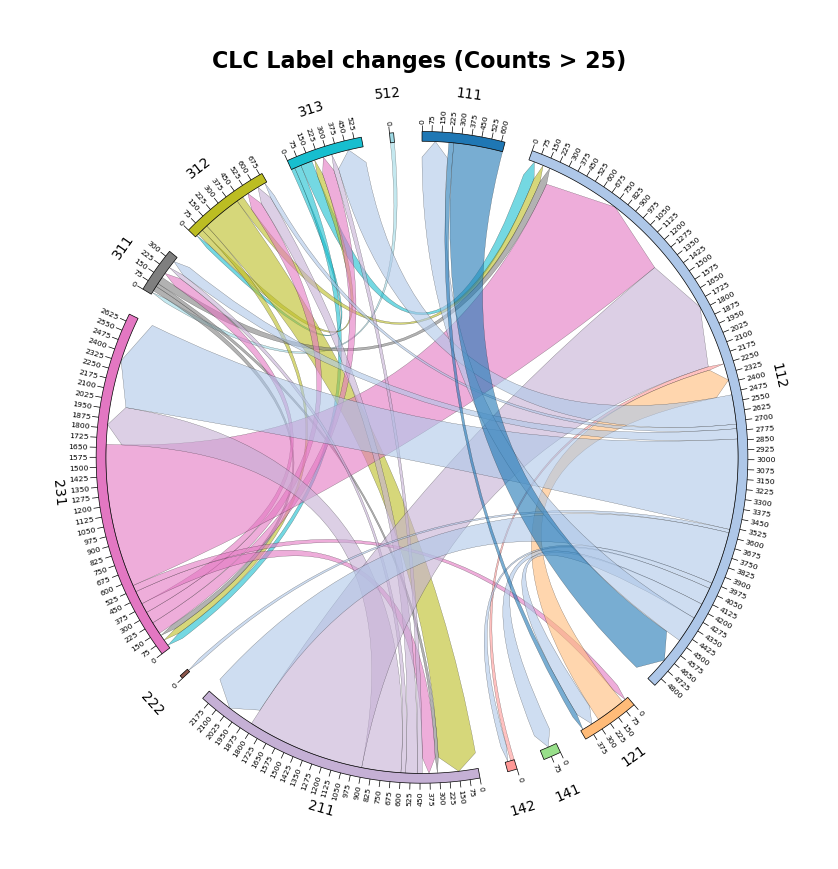

In [ ]:
# 1. Prepare data
changes_only = change_gframe[change_gframe["change"] == True].copy()

# 2. Group and count transitions
fromto_table_df = (
    changes_only.groupby(["label_drop", "label"])
    .size()
    .reset_index(name="value")
)
fromto_table_df.columns = ["from", "to", "value"]

fromto_table_df = fromto_table_df[fromto_table_df["value"] > 25]

# 3. Parse to Matrix (only contains flows > 10)
matrix = Matrix.parse_fromto_table(fromto_table_df)

# 4. Initialize Circos
circos = Circos.initialize_from_matrix(
    matrix,
    space=5,
    cmap="tab20",
    ticks_interval=75,
    ticks_kws=dict(label_orientation="vertical", label_size=5.5),
    label_kws=dict(size=10, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.2, alpha=0.6),
)

# 5. Render
fig = circos.plotfig()

fig.suptitle("CLC Label changes (Counts > 25)", fontsize=16, fontweight="bold", y=0.98)

plt.show()

C:\Users\mfher\AppData\Local\Temp\ipykernel_3424\2043899527.py:45: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  val_frame.plot(ax=ax[0], legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])


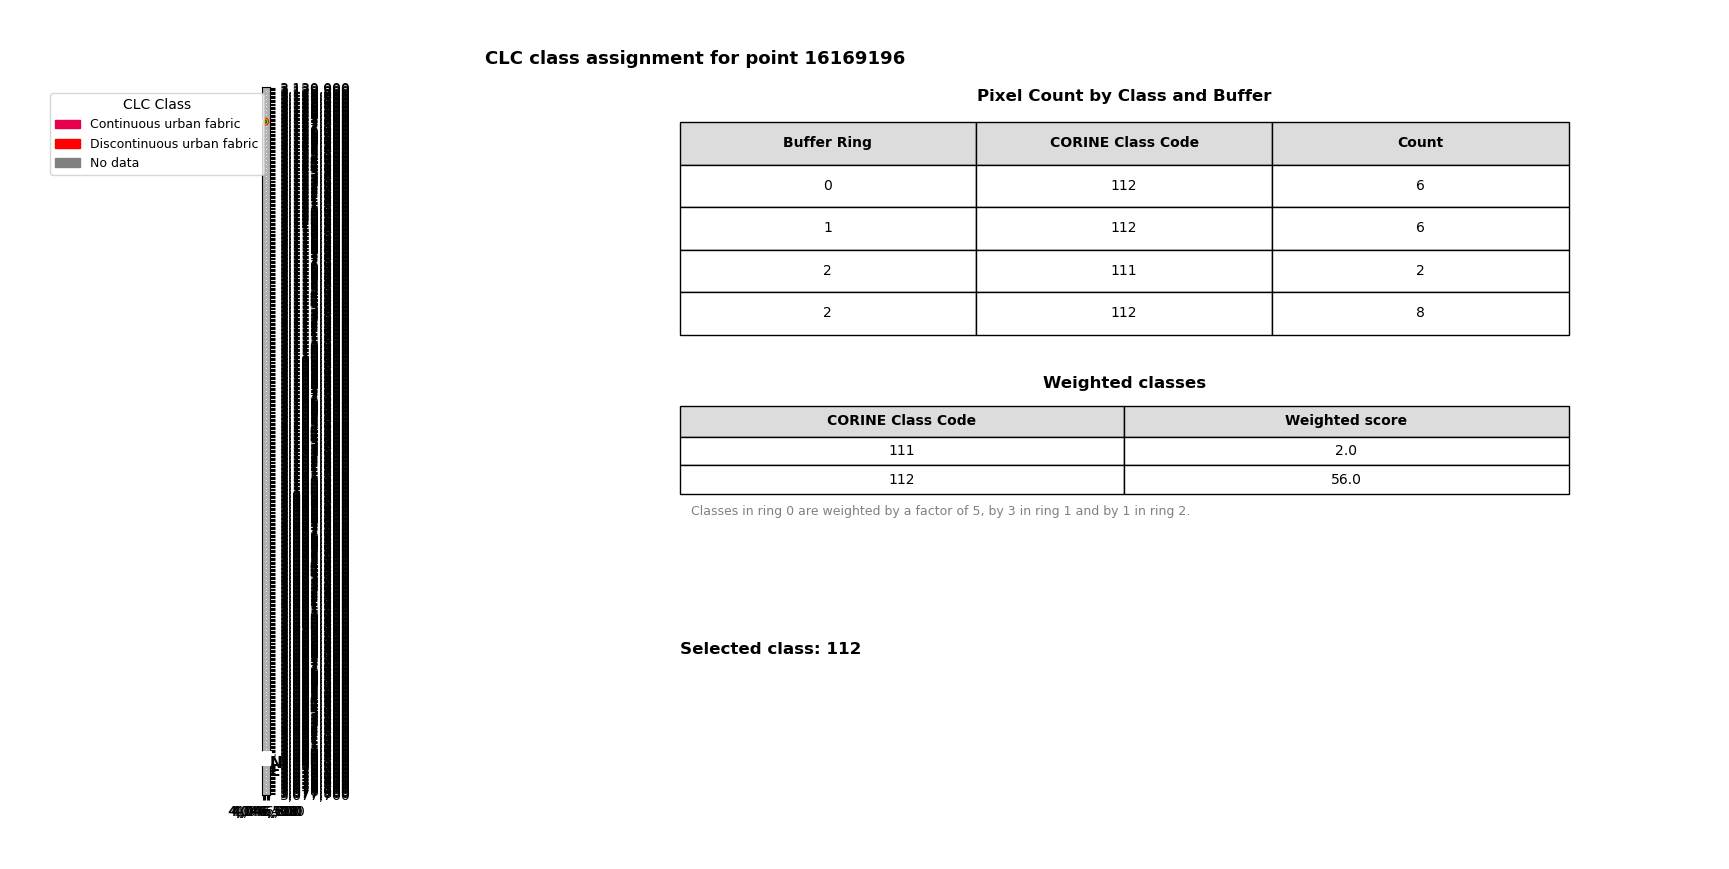

In [19]:
# Only problem with this index scheme is that the indexes are always dependent on how many points were processed previously
pidx = 72924
point_idx=0
dbf_frame = dbf_df
recording_frame=points
joined_frame=filtered_dfs
environment_frame=geo_df
grouped_frames = grouped_dfs
weighted_frames = weighted_frames
raster_crs=raster_crs

# Generate plot
fig, ax= plt.subplots(1, 2, figsize=(20, 8))

# Set Super Title as recording number
fig.suptitle(f"CLC class assignment for point {recording_frame.iloc[pidx].id}", fontsize=13, fontweight='bold')


# This value frame is needed for the CLC polygons and their legend
# Duplicates in joined_frame have to be dropped in order to facilitate a successful merge
unique_jdf = pd.concat(joined_frame[point_idx]).drop_duplicates(subset=['value'], keep='first').drop(columns=['geometry', 'Value'])
val_frame = environment_frame[point_idx].merge(unique_jdf, on = "value", how="left", suffixes=('', '_r'))
# val_frame = environment_frame.join(joined_frame, on = "value", how="left", rsuffix='_r')

# Generate a dict using the same colors as the original CLC tiff
color_dict = {
    code: to_hex((R, G, B)) # Matplotlib expects normalized (0.0 to 1.0) RGB first
    for code, R, G, B in zip(dbf_frame.CODE_18.values, dbf_frame.Red.values, dbf_frame.Green.values, dbf_frame.Blue.values)
}

# Needed to map the values to the legend descriptors
codes = val_frame[['CODE_18', 'LABEL3']].drop_duplicates().sort_values('CODE_18')['CODE_18'].tolist()
labels = val_frame[['CODE_18', 'LABEL3']].drop_duplicates().sort_values('CODE_18')['LABEL3'].replace(float("nan"), "No data").tolist()

# Maps legend labels and colors
legend_handles = [
    mpatches.Patch(
        color=color_dict.get(code, 'gray'), 
        label=label
    ) 
    for code, label in zip(codes, labels)
]

# Plot all CLC classes in the area
val_frame.plot(ax=ax[0], legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])

# Generate Legend
ax[0].legend(
    handles=legend_handles, 
    title="CLC Class", 
    loc='upper right', 
    frameon=True,
    fontsize=9
)

# Plot annotations, mainly index to the CLC classes
for idx, row in val_frame.iterrows():
    # Get square center
    centroid_x = row.geometry.centroid.x
    centroid_y = row.geometry.centroid.y
    ax[0].annotate(
        text=f"{str(idx)}",
        # Comment out below unless you want to do a sanity check
        #text=f"{str(idx)} (c: {(row.CODE_18)})",
        xy=(centroid_x, centroid_y),
        ha='center',
        va='center',
        fontsize=9,
        color='white',
        fontweight='bold'
    )


# Disable scientific format and format ticks so that they use , to separate steps of 1000
ax[0].ticklabel_format(style='plain', useOffset=False, axis='both')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Apply formatting
ax[0].xaxis.set_major_formatter(formatter)
ax[0].yaxis.set_major_formatter(formatter)

# Add y axis label
ax[0].yaxis.set_label_position("right")
ax[0].yaxis.tick_right()


# Add y axis label
xmin, xmax = ax[0].get_xlim()
ymin, ymax = ax[0].get_ylim()
x_pos = xmax + (xmax - xmin) * 0.01
y_pos = ymax + (ymax - ymin) * 0.02

ax[0].text(
    x_pos, 
    y_pos,
    "N",
    ha='left',
    va='top',
    fontsize=11,
    fontweight='bold',
    clip_on=False
)

# Add x axis label
y_pos = ymin - (ymax - ymin) * 0.0125

ax[0].text(
    x_pos, 
    y_pos,
    "E",
    ha='left',
    va='top',
    fontsize=11,
    fontweight='bold',
    clip_on=False
)


# Generate buffer colors
colors = ["red", "orange", "green"]

# Plot buffers
distance = 200
buffers = [gpd.GeoSeries(recording_frame.iloc[pidx].geometry, crs=raster_crs).buffer(d) for d in np.arange(start=distance/3, step=distance/3, stop= distance+1)]
for idx, x in enumerate(list(reversed(buffers))):
    x.plot(
        ax=ax[0], 
        facecolor='none',
        hatch='X', 
        edgecolor=colors[idx], 
        alpha=1.0,
        linewidth=2,
        zorder=5
    )

# Plot the recording point
ax[0].scatter(recording_frame.iloc[pidx].geometry.x, recording_frame.iloc[pidx].geometry.y,  color='black', edgecolor='white')

# Generate a grid at every 100m
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(100))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(100))
ax[0].grid()

# This dataframe is needed to generate the class pixel count table 
combined_df = pd.concat(map(pd.DataFrame.reset_index, grouped_frames[point_idx]), ignore_index=False, keys=[0, 1, 2], names=['df', "idx"])
cdf = combined_df.reset_index().rename(columns={"df":"Buffer Ring", "CODE_18":"CORINE Class Code", "geometry":"Count"}).drop(columns="idx")

# Used to label the pixel count table
combined_headers = cdf.columns.tolist()

# Add title as text
ax[1].text(0.5, 0.98, "Pixel Count by Class and Buffer", 
        transform=ax[1].transAxes, ha='center', fontsize=12, fontweight='bold')

# Draw the table
table1 = ax[1].table(
    cellText=cdf.values,
    colLabels=combined_headers,
    colLoc='center',
    cellLoc='center',
    loc='top',
    bbox=[0.1, 0.65, 0.8, 0.3]
)
table1.auto_set_font_size(False)
table1.set_fontsize(10)

# Highlight header
for (row, col), cell in table1.get_celld().items():
    if row == 0:
        cell.set_facecolor("#dcdcdc")
        cell.set_text_props(fontweight='bold')

# This frame is needed for the pixel weight table    
w_frame = weighted_frames[point_idx].reset_index().rename(columns={"CODE_18":"CORINE Class Code", "geometry":"Weighted score"})
weighted_headers = w_frame.columns.tolist()

# Add title as text
ax[1].text(0.5, 0.575, "Weighted classes", 
        transform=ax[1].transAxes, ha='center', fontsize=12, fontweight='bold')

# Draw the table
table2 = ax[1].table(
    cellText=w_frame.values,
    colLabels=weighted_headers,
    colLoc='center',
    cellLoc='center',
    loc='top', 
    bbox=[0.1, 0.425, 0.8, 0.125] # Adjust position
)
table2.auto_set_font_size(False)
table2.set_fontsize(10)
# Highlight header
for (row, col), cell in table2.get_celld().items():
    if row == 0:
        cell.set_facecolor("#dcdcdc")
        cell.set_text_props(fontweight='bold')
        cell.set_height(0.029)

# Hide axes
ax[1].axis('off')

# Give weighting explanation
weight_text = "Classes in ring 0 are weighted by a factor of 5, by 3 in ring 1 and by 1 in ring 2."

# Declare selected label
ax[1].text(0.11, 0.4, weight_text, 
        transform=ax[1].transAxes, ha='left', va='center', fontsize=9, color="grey")

ax[1].text(0.1, 0.2, f"Selected class: {recording_frame.iloc[point_idx].label}", fontsize= 12, fontweight = "bold")


plt.tight_layout()

In [300]:
distance = 200
corine_dir = "F:\\Persönliches\\Git\\BioOTon"
recording_dir = "Z:\\Audio_data\\Dawn_chorus_raw_data"
dir_files = os.listdir(corine_dir)
x_range=np.arange(1)#"all"

raster_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("clip.tif") for file in dir_files]))[0])
dbf_file = os.path.join(corine_dir, list(compress(dir_files, [file.endswith("vat.dbf") for file in dir_files]))[0])

# Get DBF File
dbf_data = DBF(dbf_file)
dbf_df = pd.DataFrame(iter(dbf_data))

points = getSoundLocations(recording_dir)
points["label"] = np.nan

print("Loading raster.")

if type(x_range) == str:
    x_range = np.arange(len(points))

Loading raster.


In [ ]:
with rasterio.open(raster_file) as tif:
    print("Loaded raster successfully. ")
    raster_crs = tif.crs

    # Reproject points
    if points.crs != raster_crs:
        print(f"Reprojecting points due to differing SRS.")
        points = points.to_crs(raster_crs)

    # Get raster resolution to compute pixel size
    x_res, y_res = tif.res

    for idx, content in points.iloc[x_range].iterrows():

        geo_dfs = []

        buffers = [gpd.GeoSeries(content.geometry, crs=raster_crs).buffer(d) for d in np.arange(start=distance/3, step=distance/3, stop= distance+1)]

        print(buffers)

        image_data, transformed_data = mask(
                dataset=tif,
                shapes=buffers[2].to_crs(raster_crs).geometry.tolist(),
                crop=True,
                all_touched=True 
            )
        
        print(f"Clipped raster for buffer.")

        print("Generating individual pixels.")

        # Get shape
        rows, cols = image_data.shape[1:]
        print(rows, cols)
        # Flatten image to a single band
        pixel_values = image_data[0].flatten()

        # Create arrays of all row and column indices
        col_indices, row_indices = np.meshgrid(np.arange(cols), np.arange(rows))

        xs, ys = rasterio.transform.xy(transformed_data, row_indices.flatten(), col_indices.flatten())

        print(xs, ys)

        geometries = gpd.points_from_xy(xs, ys)#.buffer(x_res/ 2, cap_style='square')[0]]

        # Create geodataframe
        geo_df = gpd.GeoDataFrame(
            pd.DataFrame({
                'value': pixel_values,
            }),
            geometry=geometries,
            crs=raster_crs
        )

        # If squares are not explicitly needed, comment this out
        geo_df['geometry'] = geo_df.buffer(x_res / 2, cap_style="square")

        print(geo_df)

        for i, buffer in enumerate(buffers):
            if i > 0:
                buffer = buffers[i].difference(buffers[i-1])

            results = geo_df.intersects(buffer.geometry.iloc[0], align=True)#.clip(buffer)

            print(results)

            print(f"Clipped raster for buffer {i}.")

            print("Generating individual pixels.")

            geo_dfs.append(geo_df[results])

        # drop pixels that occur in multiple buffers
        first_ring = pd.concat([geo_dfs[0], geo_dfs[1]])
        second_ring = pd.concat(geo_dfs)

        geo_dfs[1] = first_ring.loc[first_ring.normalize().drop_duplicates(keep=False).index]
        geo_dfs[2] = second_ring.loc[second_ring.normalize().drop_duplicates(keep=False).index]

        filtered_dfs = []

        for pos, frame in enumerate(geo_dfs):
            # Get only intersecting pixels
            # Need to combine the three buffers into one large one
            intersection_result = frame.intersects(pd.concat(buffers).union_all())

            selection = frame[intersection_result]
            joined_df = selection.join(dbf_df, on = "value")
        
            filtered_dfs.append(joined_df)
        
        grouped_dfs = []

        for pos, frame in enumerate(filtered_dfs):
            grouped_frame = filtered_dfs[pos][["CODE_18", "geometry"]].groupby("CODE_18").count()
            print(grouped_frame)
            if grouped_frame.empty:
                print(f"gdf empty")
                grouped_frame = pd.DataFrame({'CODE_18':[-128], 'geometry': [0]})
                grouped_frame.set_index('CODE_18', inplace=True)
                
            grouped_dfs.append(grouped_frame)

        # print(grouped_dfs)
        # Weigh classes and find class with highest weight
        weighted_frame = (5 * grouped_dfs[0]).add((3 * grouped_dfs[1]), fill_value=0).add((1 * grouped_dfs[2]), fill_value=0)
        print("Weighted classes:", weighted_frame)

        # Ignore NAN
        weighted_frame.loc[weighted_frame.index==-128, 'geometry'] = 0
        print(weighted_frame)

        # How to handle identical values??, e.g. recording 402
        weighted_class = weighted_frame.idxmax().item()


        print(f"Assigned class {weighted_class} to point {idx}")

        points.loc[points.index==idx, 'label'] = weighted_class

In [28]:
point = 0

geodataframe = joined_df
fig, ax= plt.subplots(1, 2, figsize=(20, 8))

fig.suptitle(f"CLC class assignment for point {points.iloc[point].id}", fontsize=13,fontweight='bold')

x_res = 100

val_frame = geo_df.join(geodataframe, on = "value", how="left", rsuffix='_r')

combined_df = pd.concat(map(pd.DataFrame.reset_index, grouped_dfs), ignore_index=False, keys=[0, 1, 2], names=['df', "idx"])
cdf = combined_df.reset_index().rename(columns={"df":"Buffer Ring", "CODE_18":"CORINE Class Code", "geometry":"Count"}).drop(columns="idx")

color_dict = {
    code: to_hex((R, G, B)) # Matplotlib expects normalized (0.0 to 1.0) RGB first
    for code, R, G, B in zip(dbf_df.CODE_18.values, dbf_df.Red.values, dbf_df.Green.values, dbf_df.Blue.values)
}

codes = val_frame[['CODE_18', 'LABEL3']].drop_duplicates().sort_values('CODE_18')['CODE_18'].tolist()
labels = val_frame[['CODE_18', 'LABEL3']].drop_duplicates().sort_values('CODE_18')['LABEL3'].tolist()

legend_handles = [
    mpatches.Patch(
        color=color_dict.get(code, 'gray'), 
        label=label
    ) 
    for code, label in zip(codes, labels)
]

# geodataframe['geometry'] = geodataframe.buffer(x_res / 2, cap_style="square")
val_frame.plot(ax=ax[0], legend= False, column="CODE_18", categorical=True, color = [color_dict.get(c, 'gray') for c in val_frame['CODE_18']])

ax[0].legend(
    handles=legend_handles, 
    title="CLC Class", 
    loc='upper right', 
    frameon=True,
    fontsize=9
)

plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

ax[0].ticklabel_format(style='plain', useOffset=False, axis='both')

formatter = ticker.StrMethodFormatter('{x:,.0f}')

ax[0].xaxis.set_major_formatter(formatter)
ax[0].yaxis.set_major_formatter(formatter)

colors = ["red", "orange", "green"]
for idx, x in enumerate(list(reversed(buffers))):
    x.plot(
        ax=ax[0], 
        facecolor='none',
        hatch='X', 
        edgecolor=colors[idx], 
        alpha=1.0,
        linewidth=2,
        zorder=5
    )

ax[0].scatter(content.geometry.x, content.geometry.y,  color='black', edgecolor='white')
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(100))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(100))

ax[0].grid()

val_frame = geo_df.join(geodataframe, on = "value", how="left", rsuffix='_r')
for idx, row in val_frame.iterrows():
    # Get square center
    centroid_x = row.geometry.centroid.x
    centroid_y = row.geometry.centroid.y
    ax[0].annotate(
        text=f"{str(idx)} (c: {(row.CODE_18)})",
        xy=(centroid_x, centroid_y),
        ha='center',
        va='center',
        fontsize=9,
        color='white',
        fontweight='bold'
    )

combined_data = [cdf.columns.values.tolist()] + cdf.values.tolist()
combined_headers = cdf.columns.tolist()

# Define cell colors (optional, for aesthetics)
cell_colors = [['#f2f2f2'] * len(combined_headers)] + [['white'] * len(combined_headers)] * len(combined_data)

# Add title as text
ax[1].text(0.5, 0.98, "Pixel Count by Class and Buffer", 
           transform=ax[1].transAxes, ha='center', fontsize=12, fontweight='bold')

# Draw the table
table1 = ax[1].table(
    cellText=cdf.values,
    colLabels=combined_headers,
    colLoc='center',
    cellLoc='center',
    loc='top',
    bbox=[0.1, 0.65, 0.8, 0.3]
)
table1.auto_set_font_size(False)
table1.set_fontsize(10)
# Highlight header
for (row, col), cell in table1.get_celld().items():
    if row == 0:
        cell.set_facecolor("#dcdcdc")
        cell.set_text_props(fontweight='bold')

w_frame = weighted_frame.reset_index().rename(columns={"CODE_18":"CORINE Class Code", "geometry":"Weighted score"})
weighted_data = [w_frame.columns.values.tolist()] +w_frame.values.tolist()
weighted_headers = w_frame.columns.tolist()


# Add title as text
ax[1].text(0.5, 0.575, "Weighted classes", 
           transform=ax[1].transAxes, ha='center', fontsize=12, fontweight='bold')
# Draw the table
table2 = ax[1].table(
    cellText=w_frame.values,
    colLabels=weighted_headers,
    colLoc='center',
    cellLoc='center',
    loc='top', 
    bbox=[0.1, 0.425, 0.8, 0.125] # Adjust position
)
table2.auto_set_font_size(False)
table2.set_fontsize(10)
for (row, col), cell in table2.get_celld().items():
    if row == 0:
        cell.set_facecolor("#dcdcdc")
        cell.set_text_props(fontweight='bold')
        cell.set_height(0.029)

# Hide axes
ax[1].axis('off')

weight_text = "Classes in ring 0 are weighted by a factor of 5, by 3 in ring 1 and by 1 in ring 2."

ax[1].text(0.11, 0.4, weight_text, 
           transform=ax[1].transAxes, ha='left', va='center', fontsize=9, color="grey")

ax[1].text(0.1, 0.2, f"Selected class: {points.iloc[point].label}", fontsize= 12, fontweight = "bold")


plt.tight_layout()
plt.show()

NameError: name 'joined_df' is not defined